## Setting Up Your Python Environment

In [1]:
# %%capture
# # Install PyTorch
# !pip install torch torchvision torchaudio

# # Install additional dependencies
# !pip install matplotlib pandas pillow tqdm lxml

# # Install package for creating visually distinct colormaps
# !pip install distinctipy

# # Install utility packages
# !pip install cjm_psl_utils cjm_pil_utils cjm_pytorch_utils cjm_torchvision_tfms

## Importing the Required Dependencies

In [2]:
# Import Python Standard Library dependencies
from functools import partial
from pathlib import Path

# Import utility functions
from cjm_pil_utils.core import get_img_files
from cjm_psl_utils.core import download_file, file_extract
from cjm_pytorch_utils.core import tensor_to_pil
from cjm_torchvision_tfms.core import ResizeMax, PadSquare, CustomRandomIoUCrop

# Import the distinctipy module
from distinctipy import distinctipy

# Import matplotlib for creating plots
import matplotlib.pyplot as plt

# Import numpy
import numpy as np

# Import the pandas package
import pandas as pd

# Do not truncate the contents of cells and display all rows and columns
pd.set_option('max_colwidth', None, 'display.max_rows', None, 'display.max_columns', None)

# Import PIL for image manipulation
from PIL import Image, ImageDraw

# Import PyTorch dependencies
import torch
from torch.utils.data import Dataset, DataLoader

import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision.tv_tensors import BoundingBoxes
from torchvision.utils import draw_bounding_boxes
import torchvision.transforms.v2  as transforms

# Import tqdm for progress bar
from tqdm.auto import tqdm

# Import tqdm for progress bar
from tqdm.auto import tqdm

# Import XML support
import xml.etree.ElementTree as ET

## Loading and Exploring the Dataset

### Setting the Directory Paths

In [3]:
# Define path to store datasets
dataset_dir = Path("./Datasets/")
# Create the dataset directory if it does not exist
dataset_dir.mkdir(parents=True, exist_ok=True)

# Define path to store archive files
archive_dir = dataset_dir/'../Archive'
# Create the archive directory if it does not exist
archive_dir.mkdir(parents=True, exist_ok=True)

# Creating a Series with the paths and converting it to a DataFrame for display
pd.Series({
    "Dataset Directory:": dataset_dir, 
    "Archive Directory:": archive_dir
}).to_frame().style.hide(axis='columns')

Dataset Directory:,Datasets
Archive Directory:,Datasets/../Archive


### Setting the Dataset Path

In [4]:
# Set the name of the dataset
dataset_name = 'cvat-keypoint-toy-dataset'

# Construct the HuggingFace Hub dataset name by combining the username and dataset name
hf_dataset = f'cj-mills/{dataset_name}'

# Create the path to the zip file that contains the dataset
archive_path = Path(f'{archive_dir}/{dataset_name}.zip')

# Create the path to the directory where the dataset will be extracted
dataset_path = Path(f'{dataset_dir}/{dataset_name}')

# Creating a Series with the dataset name and paths and converting it to a DataFrame for display
pd.Series({
    "HuggingFace Dataset:": hf_dataset, 
    "Archive Path:": archive_path, 
    "Dataset Path:": dataset_path
}).to_frame().style.hide(axis='columns')

HuggingFace Dataset:,cj-mills/cvat-keypoint-toy-dataset
Archive Path:,Datasets/../Archive/cvat-keypoint-toy-dataset.zip
Dataset Path:,Datasets/cvat-keypoint-toy-dataset


### Downloading the Dataset

In [5]:
# Construct the HuggingFace Hub dataset URL
dataset_url = f"https://huggingface.co/datasets/{hf_dataset}/resolve/main/{dataset_name}.zip"
print(f"HuggingFace Dataset URL: {dataset_url}")

# Set whether to delete the archive file after extracting the dataset
delete_archive = True

# Download the dataset if not present
if dataset_path.is_dir():
    print("Dataset folder already exists")
else:
    print("Downloading dataset...")
    download_file(dataset_url, archive_dir)    
    
    print("Extracting dataset...")
    file_extract(fname=archive_path, dest=dataset_dir)
    
    # Delete the archive if specified
    if delete_archive: archive_path.unlink()

HuggingFace Dataset URL: https://huggingface.co/datasets/cj-mills/cvat-keypoint-toy-dataset/resolve/main/cvat-keypoint-toy-dataset.zip


  0%|          | 0.00/20.1M [00:00<?, ?iB/s]

Extracting dataset...


### Getting the Image and Annotation Folders

In [6]:
 # Assuming the images are stored in a subfolder named 'images'
img_dir = dataset_path/'images/'

# Assuming annotation file is in XML format and located in any subdirectory of the dataset
annotation_file_path = dataset_path/'annotations.xml'

# Creating a Series with the paths and converting it to a DataFrame for display
pd.Series({
    "Image Folder": img_dir, 
    "Annotation File": annotation_file_path}).to_frame().style.hide(axis='columns')

Image Folder,Datasets/cvat-keypoint-toy-dataset/images
Annotation File,Datasets/cvat-keypoint-toy-dataset/annotations.xml


### Get Image File Paths

In [7]:
# Get all image files in the 'img_dir' directory
img_dict = {
    file.stem : file # Create a dictionary that maps file names to file paths
    for file in get_img_files(img_dir) # Get a list of image files in the image directory
}

# Print the number of image files
print(f"Number of Images: {len(img_dict)}")

# Display the first five entries from the dictionary using a Pandas DataFrame
pd.DataFrame.from_dict(img_dict, orient='index').head()

Number of Images: 38


,0
adorable-animal-breed-1203704,Datasets/cvat-keypoint-toy-dataset/images/adorable-animal-breed-1203704.jpg
adorable-animal-canine-1771838,Datasets/cvat-keypoint-toy-dataset/images/adorable-animal-canine-1771838.jpg
adorable-animal-canine-2173124,Datasets/cvat-keypoint-toy-dataset/images/adorable-animal-canine-2173124.jpg
adorable-animal-canine-2754695,Datasets/cvat-keypoint-toy-dataset/images/adorable-animal-canine-2754695.jpg
adorable-animal-cat-1082255,Datasets/cvat-keypoint-toy-dataset/images/adorable-animal-cat-1082255.jpg


### Get Keypoint Annotations

#### Define a function to parse the CVAT XML annotations

In [8]:
def parse_cvat_keypoint_xml(xml_content):
    """
    Parses a CVAT XML content for keypoints and converts it into a Pandas DataFrame.

    This function processes an XML file used in Computer Vision Annotation Tool (CVAT) format. 
    It extracts key information such as image ID, image name, dimensions, and keypoints.
    
    Args:
    xml_content (str): A string representation of the CVAT XML content.
    
    Returns:
    pandas.DataFrame: A DataFrame where each row represents an image and its associated data 
                      including image ID, image name, dimensions, and keypoints.
    """
    
    # Parse the XML content
    root = ET.fromstring(xml_content)
    data = {}

    # Iterating through each image element in the XML
    for image in root.findall('image'):
        # Extracting basic image information
        image_id = image.get('id')
        image_name = image.get('name')
        width = image.get('width')
        height = image.get('height')

        # Structuring image data
        image_data = {
            'Image ID': int(image_id),
            'Image Name': image_name,
            'Width': int(width),
            'Height': int(height),
            'Keypoints': []
        }

        # Iterating through keypoints within each image
        for points in image.findall('points'):
            label = points.get('label')
            keypoints = points.get('points').split(',')
            x = float(keypoints[0])
            y = float(keypoints[1])

            # Structuring keypoints data
            keypoints_data = {
                'Label': label,
                'x': x,
                'y': y
            }
            # Adding keypoints data to the image data
            image_data['Keypoints'].append(keypoints_data)

        # Adding image data to the overall data dictionary
        data[image_id] = image_data

    # Converting the data dictionary to a Pandas DataFrame
    return pd.DataFrame.from_dict(data, orient='index')

#### Load CVAT XML annotations into a DataFrame

In [9]:
# Read the XML file
with open(annotation_file_path, 'r', encoding='utf-8') as file:
    xml_content = file.read()

# Parse the XML content
annotation_df = parse_cvat_keypoint_xml(xml_content)

# Add a new column 'Image ID' by extracting it from 'Image Name'
# This assumes that the 'Image ID' is the part of the 'Image Name' before the first period
annotation_df['Image ID'] = annotation_df['Image Name'].apply(lambda x: x.split('.')[0])

# Set the new 'Image ID' column as the index of the DataFrame
annotation_df = annotation_df.set_index('Image ID')

# Display the first few rows of the DataFrame
annotation_df.head()

,Image Name,Width,Height,Keypoints
Image ID,,,,
133196,133196.jpg,960,768,"[{'Label': 'nose', 'x': 386.71, 'y': 297.11}]"
245035,245035.jpg,768,1152,"[{'Label': 'nose', 'x': 334.46, 'y': 319.58}]"
245036,245036.jpg,768,1120,"[{'Label': 'nose', 'x': 226.86, 'y': 240.8}]"
247937,247937.jpg,1152,768,"[{'Label': 'nose', 'x': 454.66, 'y': 230.04}]"
3172614,3172614.jpg,1152,768,"[{'Label': 'nose', 'x': 539.41, 'y': 608.09}]"


#### Get image classes

In [10]:
# Explode the 'boxes_df' column in the annotation_df dataframe
# Convert the resulting series to a dataframe and rename the 'boxes_df' column to 'boxes_df'
# Apply the pandas Series function to the 'boxes_df' column of the dataframe
keypoints_df = annotation_df['Keypoints'].explode().to_frame().Keypoints.apply(pd.Series)

# Get a list of unique labels in the 'annotation_df' DataFrame
class_names = keypoints_df['Label'].unique().tolist()

# Display labels using a Pandas DataFrame
pd.DataFrame(class_names)

,0
0,nose


### Visualizing Keypoint Annotations

#### Generate a color map

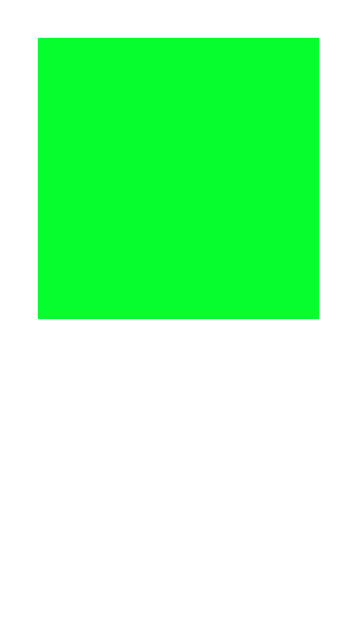

In [11]:
# Generate a list of colors with a length equal to the number of labels
colors = distinctipy.get_colors(len(class_names))

# Make a copy of the color map in integer format
int_colors = [tuple(int(c*255) for c in color) for color in colors]

# Generate a color swatch to visualize the color map
distinctipy.color_swatch(colors)

#### Download a font file

In [12]:
# Set the name of the font file
font_file = 'KFOlCnqEu92Fr1MmEU9vAw.ttf'

# Download the font file
download_file(f"https://fonts.gstatic.com/s/roboto/v30/{font_file}", "./")

The file ./KFOlCnqEu92Fr1MmEU9vAw.ttf already exists and overwrite is set to False.


#### Define the bounding box annotation function

In [13]:
draw_bboxes = partial(draw_bounding_boxes, fill=True, width=4, font=font_file, font_size=25)

### Selecting a Sample Image

#### Load the sample image

Image Dims: (1152, 768)


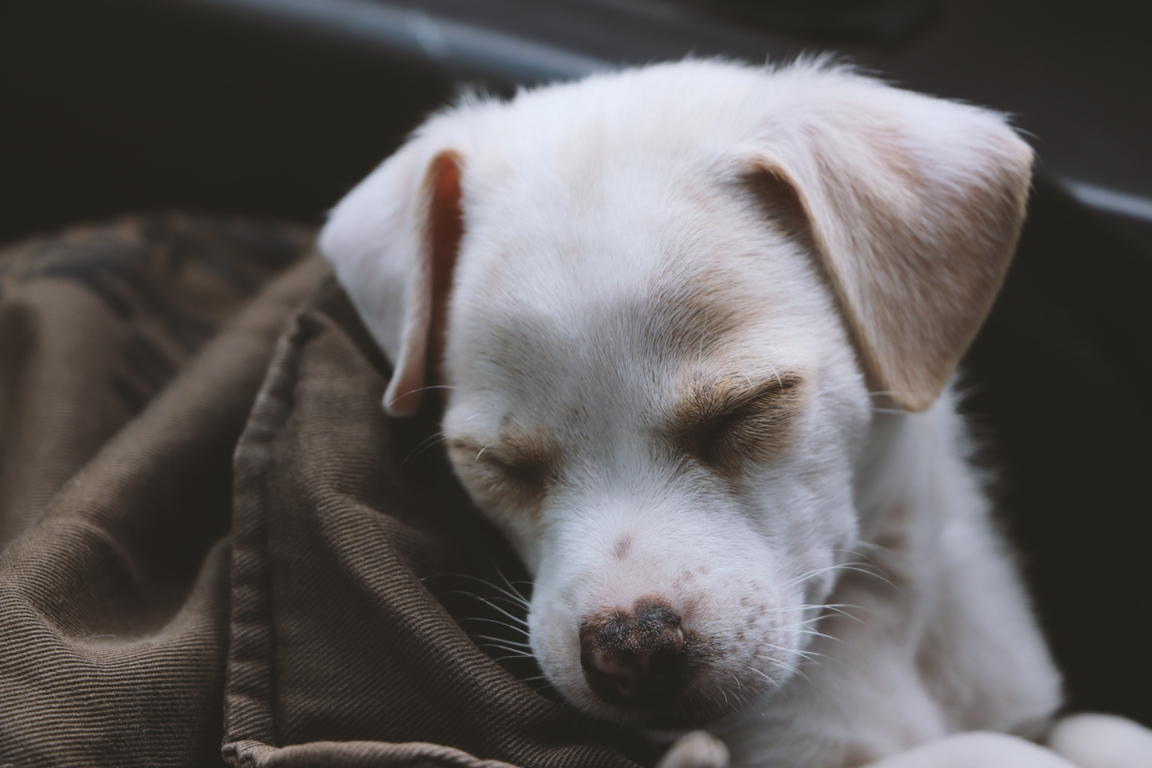

In [14]:
# Get the file ID of the first image file
file_id = list(img_dict.keys())[0]

# Open the associated image file as a RGB image
sample_img = Image.open(img_dict[file_id]).convert('RGB')

# Print the dimensions of the image
print(f"Image Dims: {sample_img.size}")

# Show the image
sample_img

#### Inspect the corresponding annotation data

In [15]:
# Get the row from the 'annotation_df' DataFrame corresponding to the 'file_id'
annotation_df.loc[file_id].to_frame()

,adorable-animal-breed-1203704
Image Name,adorable-animal-breed-1203704.jpg
Width,1152
Height,768
Keypoints,"[{'Label': 'nose', 'x': 626.61, 'y': 656.87}]"


#### Annotate sample image

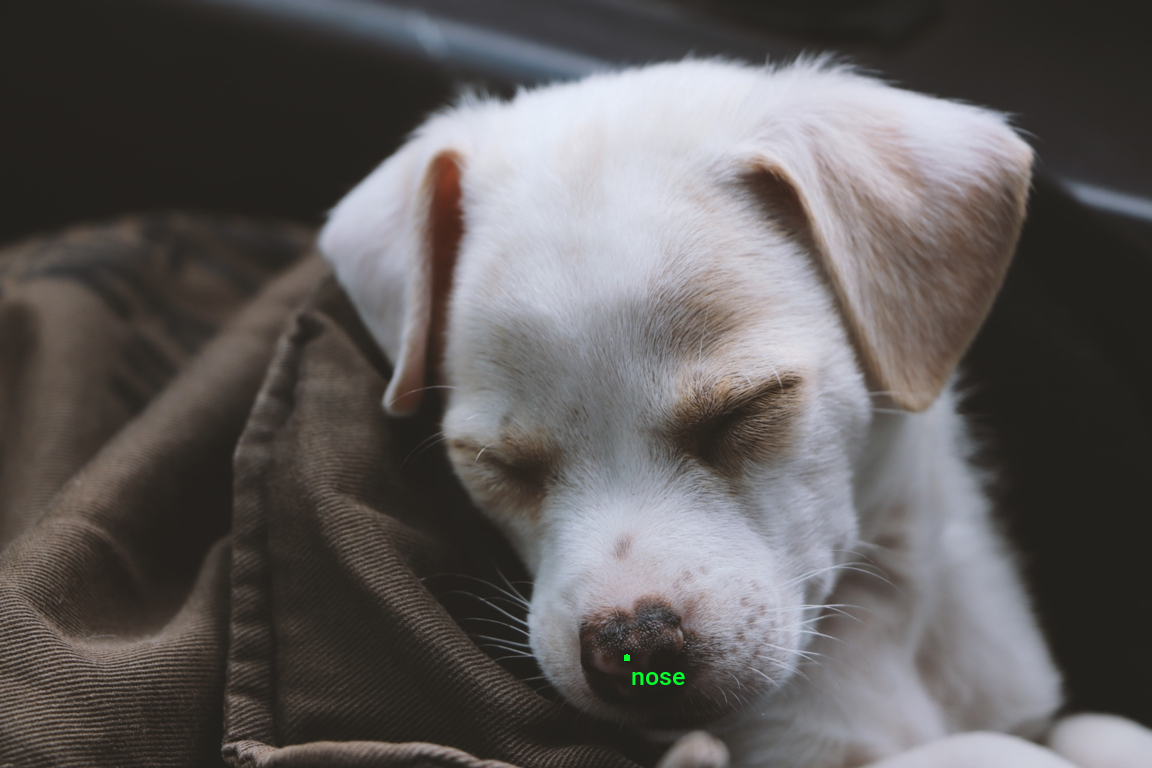

In [16]:
# Extract the labels and bounding box annotations for the sample image
labels = [keypoint['Label'] for keypoint in annotation_df.loc[file_id]['Keypoints']]
keypoints = np.array([[keypoint['x'], keypoint['y']] for keypoint in annotation_df.loc[file_id]['Keypoints']])
keypoints_bboxes = torch.cat((torch.tensor(keypoints), torch.ones(len(keypoints), 2)), dim=1)

# Annotate the sample image with labels and bounding boxes
annotated_tensor = draw_bboxes(
    image=transforms.PILToTensor()(sample_img), 
    boxes=torchvision.ops.box_convert(torch.Tensor(keypoints_bboxes), 'cxcywh', 'xyxy'), 
    labels=labels, 
    colors=[int_colors[i] for i in [class_names.index(label) for label in labels]]
)

tensor_to_pil(annotated_tensor)

## Preparing the Data

### Data Augmentation

#### Set training image size

In [17]:
# Set training image size
train_sz = 384

#### Initialize custom transforms

In [18]:
# Create a RandomIoUCrop object
iou_crop = CustomRandomIoUCrop(min_scale=0.3, 
                               max_scale=1.0, 
                               min_aspect_ratio=0.5, 
                               max_aspect_ratio=2.0, 
                               sampler_options=[0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
                               trials=400, 
                               jitter_factor=0.25)

# Create a `ResizeMax` object
resize_max = ResizeMax(max_sz=train_sz)

# Create a `PadSquare` object
pad_square = PadSquare(shift=True)

#### Test the transforms

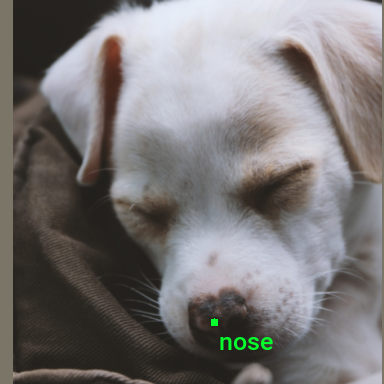

Source Image:,"(1152, 768)"
Cropped Image:,"(653, 681)"
Resized Image:,"(368, 383)"
Padded Image:,"(383, 383)"
Resized Padded Image:,"(384, 384)"


In [19]:
# Prepare bounding box targets
targets = {'boxes': BoundingBoxes(torchvision.ops.box_convert(keypoints_bboxes, 'cxcywh', 'xyxy'), 
                                format='xyxy', 
                                canvas_size=sample_img.size[::-1]), 
           'labels': labels}

# Crop the image
cropped_img, targets = iou_crop(sample_img, targets)

# Resize the image
resized_img, targets = resize_max(cropped_img, targets)

# Pad the image
padded_img, targets = pad_square(resized_img, targets)

# Ensure the padded image is the target size
resize = transforms.Resize([train_sz] * 2, antialias=True)
resized_padded_img, targets = resize(padded_img, targets)

# Annotate the augmented image with updated labels and bounding boxes
annotated_tensor = draw_bboxes(
    image=transforms.PILToTensor()(resized_padded_img), 
    boxes=targets['boxes'], 
    labels=targets['labels'], 
    colors=[int_colors[i] for i in [class_names.index(label) for label in labels]]
)

# Display the annotated image
display(tensor_to_pil(annotated_tensor))

pd.Series({
    "Source Image:": sample_img.size,
    "Cropped Image:": cropped_img.size,
    "Resized Image:": resized_img.size,
    "Padded Image:": padded_img.size,
    "Resized Padded Image:": resized_padded_img.size,
}).to_frame().style.hide(axis='columns')

### Training Dataset Class

In [20]:
class CVATKeypointDataset(Dataset):
    """
    A dataset class for handling CVAT annotated images and keypoints.

    Attributes:
        _img_keys (list): List of image keys.
        _annotation_df (DataFrame): DataFrame containing annotations.
        _img_dict (dict): Dictionary mapping image keys to image file paths.
        _class_to_idx (dict): Dictionary mapping class names to class indices.
        _transforms (function): Transformation functions to be applied to images and targets.

    Args:
        img_keys (list): List of image keys.
        annotation_df (DataFrame): DataFrame containing annotations.
        img_dict (dict): Dictionary mapping image keys to image file paths.
        class_to_idx (dict): Dictionary mapping class names to class indices.
        transforms (function, optional): Transformation functions for images and targets.
    """
    def __init__(self, img_keys, annotation_df, img_dict, class_to_idx, transforms=None):
        super().__init__()
        self._img_keys = img_keys
        self._annotation_df = annotation_df
        self._img_dict = img_dict
        self._class_to_idx = class_to_idx
        self._transforms = transforms

        self.BBOX_DIM = 4
        
    def __len__(self):
        """
        Returns the number of items in the dataset.
        
        Returns:
            int: Number of items in the dataset.
        """
        return len(self._img_keys)
        
    def __getitem__(self, index):
        """
        Retrieves an item from the dataset at the specified index.

        Args:
            index (int): Index of the item to retrieve.
        
        Returns:
            tuple: A tuple containing the image and its corresponding target dictionary.
        """
        img_key = self._img_keys[index]
        annotation = self._annotation_df.loc[img_key]
        image, target = self._load_image_and_target(annotation)
        
        if self._transforms:
            image, target = self._transforms(image, target)
        
        return image, target

    def _load_image_and_target(self, annotation):
        """
        Loads an image and its corresponding target based on the annotation.

        Args:
            annotation (DataFrame row): Annotation data for the image.
        
        Returns:
            tuple: A tuple containing the image and its target dictionary.
        """
        filepath = self._img_dict[annotation.name]
        image = Image.open(filepath).convert('RGB')
        
        # Extract keypoints from the annotation and create bounding boxes for torchvision augmentations
        keypoints = annotation['Keypoints']
        keypoints = {keypoint['Label']: [keypoint['x'], keypoint['y']] for keypoint in keypoints}
        keypoints = np.array([keypoints[name] for name in class_names], dtype=np.float32)
        keypoints_bboxes = torch.cat((torch.tensor(keypoints), torch.ones(len(keypoints), 2)), dim=1)
        keypoints_bboxes = torch.cat((torch.tensor(keypoints), torch.ones(len(keypoints), 2) * self.BBOX_DIM), dim=1)
    
        # Convert from center x, center y, width, height format to xmin, ymin, xmax, ymax format
        bbox_tensor = torchvision.ops.box_convert(keypoints_bboxes, 'cxcywh', 'xyxy')
        # Create BoundingBoxes object with the converted bounding boxes
        boxes = BoundingBoxes(bbox_tensor, format='xyxy', canvas_size=image.size[::-1])
    
        # Extract labels for keypoints and convert them to tensor
        annotation_labels = [keypoint['Label'] for keypoint in annotation['Keypoints']]
        labels = torch.tensor([self._class_to_idx[label] for label in annotation_labels])
    
        return image, {'boxes': boxes, 'labels': labels}

### Image Transforms

In [21]:
# Compose transforms for data augmentation
data_aug_tfms = transforms.Compose(
    transforms=[
        iou_crop,
        transforms.ColorJitter(
                brightness = (0.875, 1.125),
                contrast = (0.5, 1.5),
                saturation = (0.5, 1.5),
                hue = (-0.05, 0.05),
        ),
        transforms.RandomGrayscale(),
        transforms.RandomEqualize(),
        transforms.RandomPosterize(bits=3, p=0.5),
        transforms.RandomHorizontalFlip(p=0.5),
    ],
)

# Compose transforms to resize and pad input images
resize_pad_tfm = transforms.Compose([
    resize_max, 
    pad_square,
    transforms.Resize([train_sz] * 2, antialias=True)
])

# Compose transforms to sanitize bounding boxes and normalize input data
final_tfms = transforms.Compose([
    transforms.ToImage(), 
    transforms.ToDtype(torch.float32, scale=True),
    transforms.SanitizeBoundingBoxes(),
])

# Define the transformations for training and validation datasets
train_tfms = transforms.Compose([
    data_aug_tfms, 
    resize_pad_tfm, 
    final_tfms
])

### Initialize Dataset

In [22]:
# Create a mapping from class names to class indices
class_to_idx = {c: i for i, c in enumerate(class_names)}

# Instantiate the dataset using the defined transformations
train_dataset = CVATKeypointDataset(list(img_dict.keys()), annotation_df, img_dict, class_to_idx, train_tfms)

# Print the number of samples in the training dataset
pd.Series({
    'Training dataset size:': len(train_dataset),
}).to_frame().style.hide(axis='columns')

Training dataset size:,38


### Inspect Samples

**Inspect training set sample**

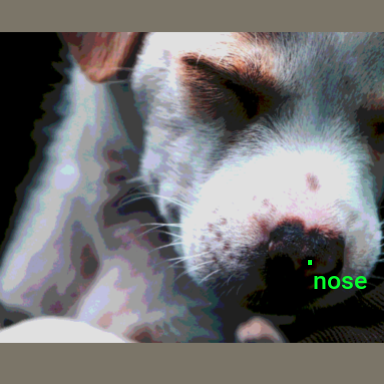

In [23]:
dataset_sample = train_dataset[0]

annotated_tensor = draw_bboxes(
    image=(dataset_sample[0]*255).to(dtype=torch.uint8), 
    boxes=dataset_sample[1]['boxes'], 
    labels=[class_names[int(i.item())] for i in dataset_sample[1]['labels']], 
    colors=[int_colors[int(i.item())] for i in dataset_sample[1]['labels']]
)

tensor_to_pil(annotated_tensor)